In [ ]:
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow
import numpy as np
import time

In [ ]:
class license_plate:
  characterRecognition = tf.keras.models.load_model('/content/drive/My Drive/SIH/char_recognition.h5')
  def cnnCharRecognition(self, img):
      dictionary = {0:'0', 1:'1', 2 :'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A',
      11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K',
      21:'L', 22:'M', 23:'N', 24:'P', 25:'Q', 26:'R', 27:'S', 28:'T', 29:'U',
      30:'V', 31:'W', 32:'X', 33:'Y', 34:'Z'}

      #blackAndWhiteChar=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      blackAndWhiteChar = cv2.resize(img,(28,28))
      image = blackAndWhiteChar.reshape((1, 28, 28, 1))                  #---- originally 100,75
      image = image / 255.0
      obj = license_plate()
      new_predictions = obj.characterRecognition.predict(image)
      char = np.argmax(new_predictions)
      return dictionary[char]

  def extract_plate(self, img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    
    #Loads the data required for detecting the license plates from cascade classifier.
    plate_cascade = cv2.CascadeClassifier('/content/drive/My Drive/SIH/indian_license_plate.xml')

    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

    for (x,y,w,h) in plate_rect:
      a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning       
      plate = plate_img[y:y+h, x:x+w, :]                                      #--orig-dim-(y+a:y+h-a,x+b:x+w-b)-------------------@harshit---increasing dimensions
      # finally representing the detected contours by drawing rectangles around the edges.
      cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
          
    return plate_img, plate # returning the processed image.


  def segment_characters(self, image) :

      # Preprocess cropped license plate image
      img = cv2.resize(image, (333, 75))
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
      img_erode = cv2.erode(img_binary, (3,3))
      img_dilate = cv2.dilate(img_erode, (3,3))

      LP_WIDTH = img_dilate.shape[0]
      LP_HEIGHT = img_dilate.shape[1]

      # Make borders white
      img_dilate[0:3,:] = 255
      img_dilate[:,0:3] = 255
      img_dilate[72:75,:] = 255
      img_dilate[:,330:333] = 255

      # Estimations of character contours sizes of cropped license plates
      dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

      # Get contours within cropped license plate
      obj = license_plate()
      char_list = obj.find_contours(dimensions, img_dilate)

      return char_list



  # Match contours to license plate or character template
  def find_contours(self, dimensions, img) :

      # Find all contours in the image
      cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

      # Retrieve potential dimensions
      lower_width = dimensions[0]
      upper_width = dimensions[1]
      lower_height = dimensions[2]
      upper_height = dimensions[3]
      

      # Check largest 5 or  15 contours for license plate or character respectively
      cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

      x_cntr_list = []
      target_contours = []
      img_res = []
      for cntr in cntrs :
          #detects contour in binary image and returns the coordinates of rectangle enclosing it
          intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
          
          #checking the dimensions of the contour to filter out the characters by contour's size
          if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
              x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

              char_copy = np.zeros((44,24))
              #extracting each character using the enclosing rectangle's coordinates.
              char = img[intY:intY+intHeight, intX:intX+intWidth]
              char = cv2.resize(char, (20, 40))

              # Make result formatted for classification: invert colors
              char = cv2.subtract(255, char)

              # Resize the image to 24x44 with black border
              char_copy[2:42, 2:22] = char
              char_copy[0:2, :] = 0
              char_copy[:, 0:2] = 0
              char_copy[42:44, :] = 0
              char_copy[:, 22:24] = 0

              img_res.append(char_copy) #List that stores the character's binary image (unsorted)

      #Return characters on ascending order with respect to the x-coordinate (most-left character first)
      
      #arbitrary function that stores sorted list of character indeces
      indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
      img_res_copy = []
      for idx in indices:
          img_res_copy.append(img_res[idx])# stores character images according to their index
      img_res = np.array(img_res_copy)

      return img_res


In [ ]:
"""start=time.time()
frame=cv2.imread("/content/drive/My Drive/SIH/car1.jpg")
cv2_imshow(frame)

obj = license_plate()

plate_img,plate=obj.extract_plate(frame)


print("Original image wihtout any changes")
cv2_imshow(frame)


cv2_imshow(plate_img)
print("Localized License Plate")
cv2_imshow(plate)

li=obj.segment_characters(plate)
print("No. of alphanumerics in number plate")
print(len(li))
for i in li:
  cv2_imshow(i)
  print(obj.cnnCharRecognition(i))

end=time.time()

print((end-start))
"""

'start=time.time()\nframe=cv2.imread("/content/drive/My Drive/SIH/car1.jpg")\ncv2_imshow(frame)\n\nobj = license_plate()\n\nplate_img,plate=obj.extract_plate(frame)\n\n\nprint("Original image wihtout any changes")\ncv2_imshow(frame)\n\n\ncv2_imshow(plate_img)\nprint("Localized License Plate")\ncv2_imshow(plate)\n\nli=obj.segment_characters(plate)\nprint("No. of alphanumerics in number plate")\nprint(len(li))\nfor i in li:\n  cv2_imshow(i)\n  print(obj.cnnCharRecognition(i))\n\nend=time.time()\n\nprint((end-start))\n'

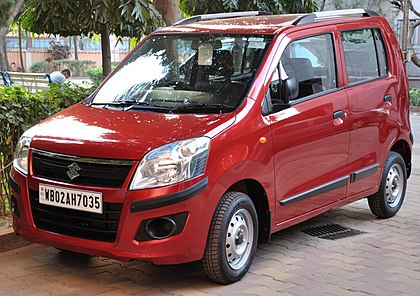

UnboundLocalError: ignored

In [ ]:
start=time.time()
frame=cv2.imread("/content/drive/My Drive/SIH/car4.jpeg")
cv2_imshow(frame)

obj = license_plate()

plate_img,plate=obj.extract_plate(frame)


print("Original image wihtout any changes")
cv2_imshow(frame)


cv2_imshow(plate_img)
print("Localized License Plate")
cv2_imshow(plate)


end=time.time()

print((end-start))

In [ ]:
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import numpy as np
 
cv2_imshow(plate)
# load the example image and convert it to grayscale
gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
 
# check to see if we should apply thresholding to preprocess the
# image


preproc = "blur"
if preproc == "thresh":
	gray = cv2.threshold(gray, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
# make a check to see if median blurring should be done to remove
# noise
elif preproc == "blur":
	gray = cv2.medianBlur(gray, 3)
 
# write the grayscale image to disk as a temporary file so we can
# apply OCR to it
"""
kernel = np.ones((5,5),np.uint8)
gray = cv2.dilate(gray,kernel,iterations = 1)
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)
# load the image as a PIL/Pillow image, apply OCR, and then delete
# the temporary file
"""

text = pytesseract.image_to_string(plate)
#os.remove(filename)
print(text)
 
# show the output images



MH146$5411)


In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,686 kB/s)
Selecting previously unselect

In [ ]:
! pip install Pillow
! pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=685a4be56050d13add67fe92440d7e987ed6e7b11789f826018fd8450d82a801
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract


In [ ]:
pytesseract.get_tesseract_version()


LooseVersion ('4.0.0-beta.1')